In [1]:
# python basic pacakages
import aifc
import os
import datetime
from os import listdir
from os.path import isfile, join
import csv

# required packags
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import mlab
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# my packages
from DataManager.Audio import *
from DataManager.General import *

In [2]:
# labels_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train.csv"
# train_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train"

labels_path = "data/train.csv"
train_path = "data/train"
redux_train_path = "data/train2"

audiofiles = [os.path.join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]
audiofiles_redux = [os.path.join(redux_train_path, f) 
                    for f in listdir(redux_train_path) if isfile(join(redux_train_path, f))]

limitator = None

In [3]:
np.array([int(clip_name[-5]) for clip_name in audiofiles_redux]).sum()/len(audiofiles_redux)

0.11028197571121005

In [4]:
labels_dict = get_labels(labels_path)

seconds_in_sound = 1.7
p_cut = seconds_in_sound/2
top_hz = 50

# Get a random permutation to remove ordering bias
np.random.shuffle(audiofiles_redux)

# convert the list of files to numpy arrays and select a random smaller version if limitador is not None
X_path = np.array(audiofiles_redux)[:limitator]

# Start the process of data extraction, spectrogram transformation and data enhancement
print('Generating train and test split')
X_train_path, X_test_path = train_test_split(X_path, test_size=0.2)

# X_train_path = np.concatenate([X_train_path, audiofiles_redux])

print('Getting test spectrograms')
X_test, Y_test = get_spects(X_test_path, labels_dict, p=p_cut, top_hz=top_hz)

# print('Getting test spectrograms')
# X_train, Y_train = get_spects(X_train_path, labels_dict)

print('Getting train spectrograms + enhancement')
X_train, Y_train = get_spects_enhanced(X_train_path, labels_dict, p=p_cut, top_hz=top_hz)

# print('Getting even more data adding noise to whale calls')
X_enhanced, Y_enhanced = enhance_with_noise(X_train, Y_train)

X_train, Y_train = np.concatenate([X_train, X_enhanced]), np.concatenate([Y_train, Y_enhanced])

print('Test', X_test.shape)

print('Train', X_train.shape)


Generating train and test split
Getting test spectrograms
Getting train spectrograms + enhancement
Test (8458, 50, 50)
Train (113751, 50, 50)


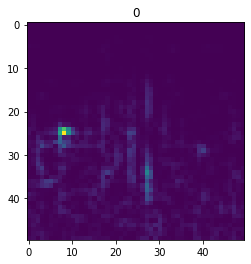

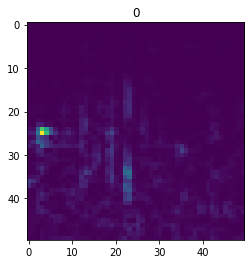

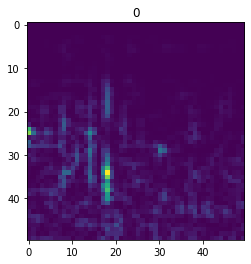

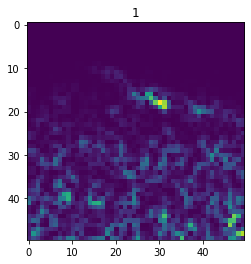

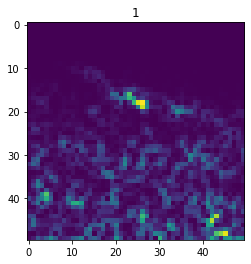

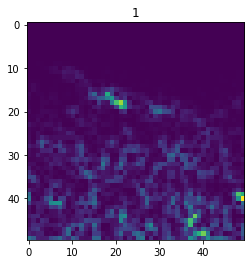

0.055078089245054744


In [21]:
def f(x):
    return x / x.max()
    
for i in range(X_train.shape[0]):
    n_index = i
    X_train_t = np.array(list(map(f, X_train)))
    plt.imshow(X_train_t[n_index])
    plt.title(Y_train[n_index])
    plt.show()
    if i > 4:
        print(X_train_t[n_index].mean())
        break

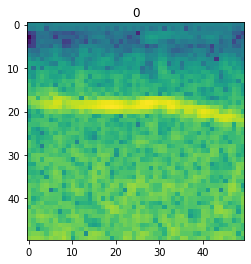

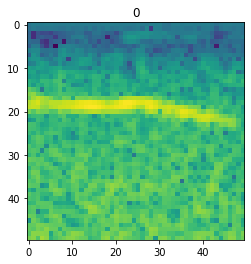

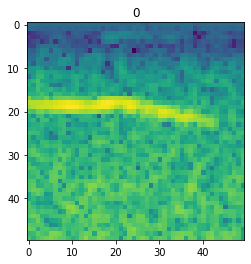

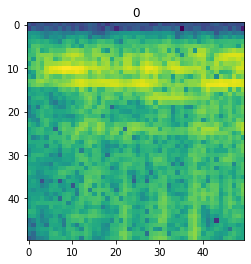

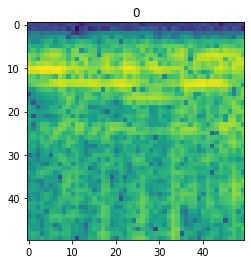

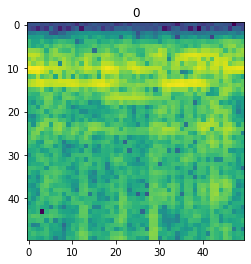

5.343718780749894


In [6]:
def f(x):
    return np.log(x)
    
for i in range(X_train.shape[0]):
    n_index = i
    X_train_t = np.array(list(map(f, X_train)))
    plt.imshow(X_train_t[n_index])
    plt.title(Y_train[n_index])
    plt.show()
    if i > 4:
        print(X_train_t[n_index].mean())
        break


## Normalize small

In [6]:

# def imagery(x, new_shape, top_hz):

#     return np.array(Image.fromarray(X_train[0][:top_hz]).convert("L").resize(new_shape))

def f(x):
    return x / x.max()

def log_norm(x):
    log_spect = np.log(x + 1)
    return log_spect / log_spect.max()

def f_05(x):
    x_min = x.min()
    return (x - x_min) / (x.max() - x_min) - .5


def f_norm(x):
    x_min = x.min()
    return (x - x.mean()) / x.std()
    

X_train = np.array(list(map(log_norm, X_train)))  # lambda x: imagery(x, [32,32], 60), X_train)))
X_test = np.array(list(map(log_norm, X_test)))  # lambda x: imagery(x, [32,32], 60), X_test)))


In [7]:
print('Test: Whale %.4f, Not Whale %.4f' % ((Y_test == '1').sum() / Y_test.shape[0], 
                                            (Y_test == '0').sum() / Y_test.shape[0]))

print('Train: Whale %.4f, Not Whale %.4f' % ((Y_train == '1').sum()  / Y_train.shape[0], 
                                             (Y_train == '0').sum()  / Y_train.shape[0]) )

Test: Whale 0.1140, Not Whale 0.8860
Train: Whale 0.2147, Not Whale 0.7853


In [8]:
'Tamaño en memoria de los datos de training aprox: %.2fGB' % (X_train.nbytes/2**10/2**10/2**10)

'Tamaño en memoria de los datos de training aprox: 2.12GB'

In [9]:
Y_train, Y_test = Y_train.astype(int), Y_test.astype(int)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

Y_train, Y_test = tf.keras.utils.to_categorical(Y_train, 2), tf.keras.utils.to_categorical(Y_test, 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [10]:
def create_base_network(input_shape, kernel_size=(6,6), final_dimension=12, regularization=0.011):
    # model building
    model = tf.keras.models.Sequencial()
    # convolutional layer with rectified linear unit activation
    # flatten since too many dimensions, we only want a classification output
    model.add(tf.keras.models.Conv2D(1, kernel_size=kernel_size,
                     activation='relu',
                     input_shape=input_shape, kernel_initializer=init,
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l1(regularization),#0.011
                bias_regularizer=regularizers.l1(regularization)))#0.011
    
    model.add(tf.keras.models.Dropout(0.5))
    model.add(tf.keras.models.Conv2D(1, kernel_size=kernel_size,
                    activation='relu', kernel_initializer=init,
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l1(regularization),#0.011
                bias_regularizer=regularizers.l1(regularization)))#0.011
    
    model.add(tf.keras.models.Dropout(0.5))
    # things to test in order to increase the performance of the mdel
    # play a little with the kernel sizes - test values: (6,6)
    # change the optimization function - 
    model.add(tf.keras.models.Flatten())
    # embedding sizes with better results seem to be between [8,15[
    model.add(tf.keras.models.Dense(final_dimension, activation='softmax', kernel_initializer=init,
                bias_initializer='zeros'))#13
    print(model.summary())
    return model


class siamese:
    def __init__(self, input_shape, regularization=0.011, kernel_size=(6,6), final_dimension=12, learning_rate=0.0004, margin=1.2):
        self.base_network = create_base_network(input_shape, kernel_size, final_dimension, regularization)

        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)

        # because we re-use the same instance `base_network`,
        # the weights of the network
        # will be shared across the two branches
        processed_a = self.base_network(input_a)
        processed_b = self.base_network(input_b)

        distance = Lambda(cosine_distance,  # compare this results with euclidean
                          output_shape=cos_dist_output_shape)([processed_a, 
                          processed_b])

        model = Model([input_a, input_b], distance)

        adam = Adam(lr=learning_rate)
        loss_function = contrastive_loss(margin)
        model.compile(loss=loss_function.loss, optimizer=adam, metrics=[accuracy])
        self.model = model

    def save_base_network(self, k):
        (self.base_network).save_weights("./validation_models/base_network_partition_" + str(k) + ".h5")
        
        
class winners:
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(20, kernel_size=(7, 7), activation=tf.nn.relu, 
                                   input_shape=X_train.shape[1:], name='Conv1'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation=tf.nn.relu, name='Conv2'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation=tf.nn.relu, name="Dense1"),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(2, activation=tf.nn.softmax, name="Softmax")
            ])
    
class winners_regression:
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(20, kernel_size=(7, 7), activation=tf.nn.relu, 
                                   input_shape=X_train.shape[1:], name='Conv1'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation=tf.nn.relu, name='Conv2'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation=tf.nn.relu, name="Dense1"),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name="Regression")
            ])
    
class bigger:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(7, 7), activation='relu', input_shape=X_train.shape[1:]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
class cnn32:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(7, 7), activation='relu', input_shape=X_train.shape[1:]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model = winners

opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# opt = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.model.compile(optimizer=opt,
                    loss='binary_crossentropy', # loss for classification
#                     loss='mse',  # loss for classification
                    metrics=['accuracy'])


print('Training model')
history = model.model.fit(X_train, Y_train, epochs=100, verbose=2, validation_split=0.2)
score = model.model.evaluate(X_test, Y_test)


Training model
Train on 91000 samples, validate on 22751 samples
Epoch 1/100
 - 205s - loss: 0.0754 - acc: 0.9712 - val_loss: 0.8565 - val_acc: 0.7920
Epoch 2/100
 - 214s - loss: 0.0708 - acc: 0.9719 - val_loss: 0.5986 - val_acc: 0.8506
Epoch 3/100
 - 230s - loss: 0.0669 - acc: 0.9738 - val_loss: 0.5262 - val_acc: 0.8710
Epoch 4/100
 - 203s - loss: 0.0640 - acc: 0.9753 - val_loss: 0.4689 - val_acc: 0.8890
Epoch 5/100
 - 210s - loss: 0.0604 - acc: 0.9759 - val_loss: 0.6617 - val_acc: 0.8599
Epoch 6/100
 - 204s - loss: 0.0574 - acc: 0.9768 - val_loss: 0.4563 - val_acc: 0.8968
Epoch 7/100
 - 220s - loss: 0.0571 - acc: 0.9777 - val_loss: 0.7194 - val_acc: 0.8455
Epoch 8/100
 - 204s - loss: 0.0539 - acc: 0.9788 - val_loss: 0.9362 - val_acc: 0.8058
Epoch 9/100
 - 200s - loss: 0.0506 - acc: 0.9801 - val_loss: 0.7524 - val_acc: 0.8548
Epoch 10/100
 - 199s - loss: 0.0486 - acc: 0.9813 - val_loss: 0.7220 - val_acc: 0.8647
Epoch 11/100
 - 199s - loss: 0.0459 - acc: 0.9820 - val_loss: 0.8223 - val

In [ ]:
score

[0.5788849399394312, 0.91816664]
Finished at 2019-10-11 05:14:03.781427, saving the results as graphs.


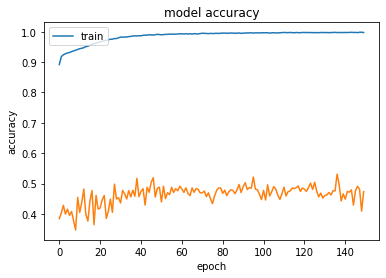

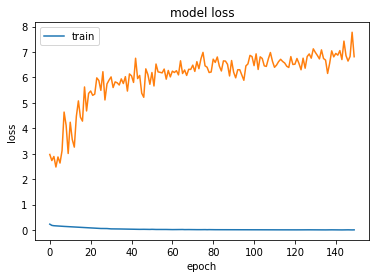

In [44]:
print(score)
print('Finished at {}, saving the results as graphs.'.format(datetime.datetime.now()))

#Accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_accuracy' + str(score[1]) + '.pdf')
plt.show()

#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_loss' + str(score[1]) + '.pdf')
plt.show()

In [15]:
# y_hat

In [45]:
#Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
import numpy as np
#Compute probabilities
Y_pred = model.model.predict(X_test)
#Assign most probable label
y = np.argmax(Y_test, axis=1)  # Y_test #
y_hat = np.argmax(Y_pred, axis=1)  # np.round(Y_pred)  #
#Plot statistics
print('Analysis of results')
target_names = ['no_whale', 'whale']
print(classification_report(y, y_hat, target_names=target_names))
print(confusion_matrix(y, y_hat))
print(roc_auc_score(y, y_hat))

y_pred_proba = winners.model.predict_proba(X_test)[::,1]

print('\nROC AUC with probabilities %.4f' % roc_auc_score(y, y_pred_proba))


Analysis of results
              precision    recall  f1-score   support

    no_whale       0.94      0.95      0.95      4590
       whale       0.83      0.81      0.82      1410

    accuracy                           0.92      6000
   macro avg       0.89      0.88      0.89      6000
weighted avg       0.92      0.92      0.92      6000

[[4360  230]
 [ 261 1149]]
0.8823923422797014

ROC AUC with probabilities 0.9723


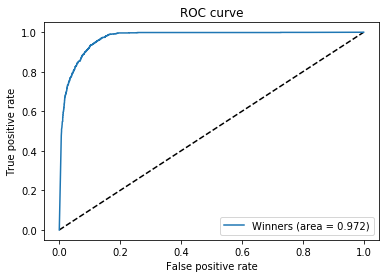

In [46]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# y_pred_proba = winners.model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)
plt.plot(fpr,tpr,label='Winners (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [47]:
print('Getting other dataset test spectrograms')
X_test_, Y_test_ = get_spects(audiofiles, labels_dict, p=p_cut, top_hz=top_hz)

Getting other dataset test spectrograms


In [48]:
X_test_ = np.array(list(map(log_norm, X_test_)))
Y_test_ = Y_test_.astype(int)
Y_test_ = tf.keras.utils.to_categorical(Y_test_, 2)
X_test_ = X_test_.reshape(X_test_.shape[0], X_test_.shape[1], X_test_.shape[2], 1)

score = model.model.evaluate(X_test_, Y_test_)
print('Other dataset score: {}'.format(score))

#Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
import numpy as np
#Compute probabilities
Y_pred = model.model.predict(X_test_)
#Assign most probable label
y = np.argmax(Y_test_, axis=1)  # Y_test #
y_hat = np.argmax(Y_pred, axis=1)  # np.round(Y_pred)  #
#Plot statistics
print('Analysis of results')
target_names = ['no_whale', 'whale']
print(classification_report(y, y_hat, target_names=target_names))
print(confusion_matrix(y, y_hat))
print(roc_auc_score(y, y_hat))

y_pred_proba = winners.model.predict_proba(X_test_)[::,1]

print('\nROC AUC with probabilities %.4f' % roc_auc_score(y, y_pred_proba))


42304/42304 [==============================] - 29s 682us/sample - loss: 0.7313 - acc: 0.9203
Other dataset score: [0.731286536474562, 0.92031485]
Analysis of results
              precision    recall  f1-score   support

    no_whale       0.92      0.99      0.96     37269
       whale       0.89      0.38      0.53      5035

    accuracy                           0.92     42304
   macro avg       0.91      0.68      0.74     42304
weighted avg       0.92      0.92      0.91     42304

[[37044   225]
 [ 3146  1889]]
0.6845682972153151

ROC AUC with probabilities 0.9315


In [53]:
(1889 + 3146) / (37044 + 225 + 3146 + 1889)

0.11901947806354009

In [ ]:
# python basic pacakages
import aifc
import os
import datetime
from os import listdir
from os.path import isfile, join
import csv

# required packags
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import mlab
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# my packages
from DataManager.Audio import *
from DataManager.General import *


def preprocess(files_train, files_test, labels, normalization_function, to_categorical=False):

    x_test, y_test = get_spects(files_test, labels)

    x_train, y_train = get_spects_enhanced(files_train, labels)
    x_enhanced, y_enhanced = enhance_with_noise(x_train, y_train)

    x_train, y_train = np.concatenate([x_train, x_enhanced]), np.concatenate([y_train, y_enhanced])

    y_train, y_train = y_train.astype(int), y_test.astype(int)
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

    y_train, y_test = tf.keras.utils.to_categorical(y_train, 2), tf.keras.utils.to_categorical(y_test, 2)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

    x_train = np.array(list(map(normalization_function, x_train)))
    x_test = np.array(list(map(normalization_function, x_test)))

    y_train, y_test = y_train.astype(int), y_test.astype(int)
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

    if to_categorical:
        y_train, y_test = tf.keras.utils.to_categorical(y_train, 2), tf.keras.utils.to_categorical(y_test, 2)
    else:
        y_train, y_test = y_train.astype(int), y_test.astype(int)

    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

    return x_train, y_train, x_test, y_test


def k_fold_cross_validation(x_files, labels_path, model, f_preprocess, n_splits=5, shuffle=True, seed=None):

    if seed is not None:
        np.random.seed(seed)
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)

    else:
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle)

    cvscores = []
    cvhistories = []

    opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    labels_dict = get_labels(labels_path)

    for train, test in kfold.split(x_files,  map(lambda x: labels_dict[x], x_files)):
        x_train, y_train, x_test, y_test = f_preprocess(x_files[train], x_files[test], labels_dict)
        # Compile model
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        history = model.model.fit(x_train, y_train, epochs=150, verbose=2, validation_split=0.2)
        score = model.model.evaluate(x_test, y_test)
        cvhistories.append(history)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))
        cvscores.append(score[1] * 100)


In [86]:
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train in kfold.split(X):
  # create model
	model = Sequential()
	model.add(Dense(12, input_dim=8, activation='relu'))
	model.add(Dense(8, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# Fit the model
	model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
	# evaluate the model
	scores = model.evaluate(X[test], Y[test], verbose=0)
	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

Using TensorFlow backend.


OSError: pima-indians-diabetes.csv not found.

[]

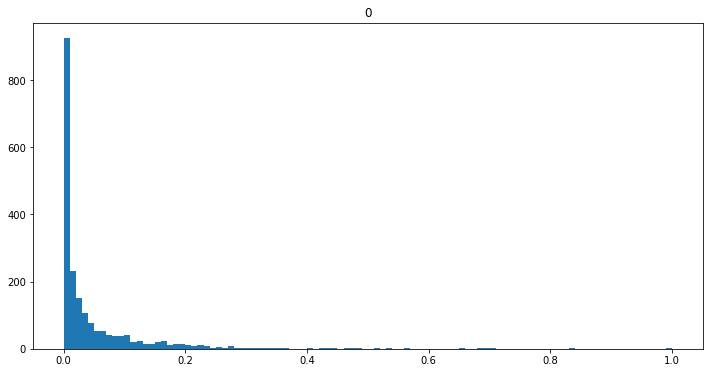

In [13]:
n_s = 4
plt.figure(figsize=(12,6))
plt.title(np.argmax(Y_test[n_s]))
q = plt.hist(X_train[n_s].flatten(), bins=100)
plt.plot()